In [1]:
from keras.models import Sequential 
from keras.layers import Dense
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
from copy import deepcopy
import sys
import keras
sys.path.append('..')
import condense
tf.get_logger().setLevel(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# from utils import visualize_kernel, calculate_model_sparsity

In [2]:
# Construct a tf.data.Dataset
ds = tfds.load('iris', split='train', shuffle_files=True, as_supervised=True)
ds = ds.repeat()

def generator(batch_size):
    while True:
        X, y = next(tfds.as_numpy(ds.batch(batch_size)))
        yield X.reshape(batch_size, 4), keras.utils.to_categorical(y, 3)
        
gen = generator(40)

Unpruned Model Evaluation Loss: 0.3340647220611572


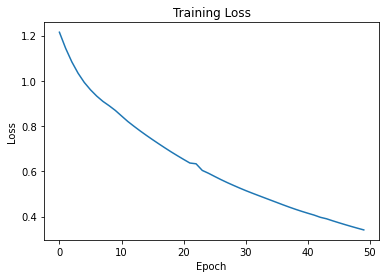

In [3]:
model = Sequential([
    Dense(40, input_shape=(4,), activation='relu'),
    Dense(80, activation='relu'),
    Dense(10, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile('adam', 'categorical_crossentropy')
hist = model.fit(gen, epochs=50, steps_per_epoch=1, verbose=0)
plt.plot(hist.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
unpruned_acc = model.evaluate(gen, steps=1, verbose=0)
print(f'Unpruned Model Evaluation Loss: {unpruned_acc}')
model.save('./models/iris.h5')

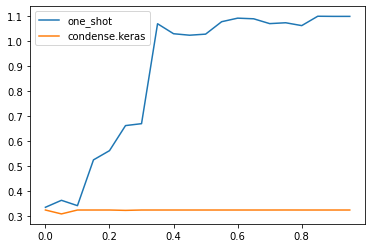

In [21]:
model = keras.models.load_model('./models/iris.h5')
def eval(acc):
    pruned_model = condense.one_shot(model, acc)
    condense.utils.model_utils.calc_model_sparsity(pruned_model)
    pruned_model.compile('adam', 'categorical_crossentropy')
    return pruned_model.evaluate(gen, steps=1, verbose=0)

def condense_keras(acc):
    model = keras.models.load_model('./models/iris.h5')
    p = condense.keras.wrap_model(model, condense.optimizer.sparsity_functions.Constant(acc))
    p.compile('adam', 'categorical_crossentropy')
    p.fit(gen, epochs=1, steps_per_epoch=1, verbose=0)
    return p.evaluate(gen, steps=1, verbose=0)


targets = np.linspace(0,0.95, 20)
plt.plot(targets, [eval(acc) for acc in targets], label='one_shot')
plt.plot(targets, [condense_keras(acc) for acc in targets], label='condense.keras')
plt.legend()

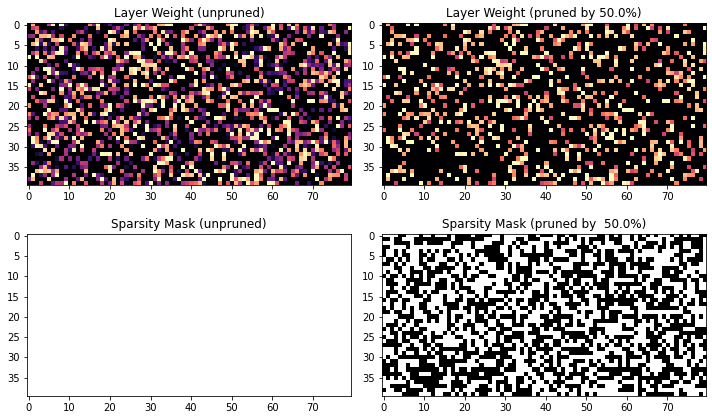

In [82]:
model = keras.models.load_model('models/iris.h5')
layer = 1
sparsity = 0.5

plt.figure(figsize=(10, 6))
plt.subplot(2,2,1)
plt.imshow(model.layers[layer].kernel, cmap='magma', vmin=0, vmax=.2)
plt.title('Layer Weight (unpruned)')

plt.subplot(2,2,3)
plt.imshow(model.layers[layer].kernel == 0, cmap='binary', vmin=0, vmax=1)
plt.title('Sparsity Mask (unpruned)')

keras_pruned = condense.keras.wrap_model(model,
                                        condense.optimizer.sparsity_functions.Constant(sparsity))
keras_pruned.compile('adam', 'categorical_crossentropy')
keras_pruned.fit(gen, epochs=1, steps_per_epoch=1, callbacks=[condense.keras.PruningCallback()], verbose=0)

plt.subplot(2,2,2)
plt.imshow(keras_pruned.layers[layer].layer.kernel, cmap='magma', vmin=0, vmax=0.2)
plt.title(f'Layer Weight (pruned by {sparsity*100}%)')

plt.subplot(2,2,4)
plt.imshow(keras_pruned.layers[layer].layer.kernel == 0, cmap='binary', vmin=0, vmax=1)
plt.title(f'Sparsity Mask (pruned by  {sparsity*100}%)')

plt.tight_layout()